## SET LIBARY

In [1]:
import random
import numpy as np
np.random.seed(13)
import gensim

import keras.backend as K
from keras.models import Sequential
from keras.layers import Embedding, Reshape, Activation, Input, Lambda, Dense

from keras.preprocessing import sequence
from keras.layers.merge import Dot
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import skipgrams
from IPython.display import Image

Using TensorFlow backend.


In [ ]:
!pip install pydot
!pip install gensim

## DATALOADER

In [2]:
def dataloader(corpus, window_size, vocab_size):
    maxlen = window_size*2
    corpus = tokenizer.texts_to_sequences(corpus)
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            contexts = []
            labels   = []            
            s = index - window_size
            e = index + window_size + 1
            
            contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
            labels.append(word)
            x = sequence.pad_sequences(contexts, maxlen=maxlen)
            y = np_utils.to_categorical(labels, vocab_size)
            yield (x, y)

In [3]:
path = get_file('alice.txt', origin='http://www.gutenberg.org/files/11/11-0.txt')
corpus = open(path, encoding="utf-8").readlines()
corpus = [sentence for sentence in corpus if sentence.count(' ') >= 2]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size: {}".format(vocab_size))

Vocabulary size: 3388


In [4]:
corpus[:5]

['\ufeffProject Gutenberg’s Alice’s Adventures in Wonderland, by Lewis Carroll\n',
 'This eBook is for the use of anyone anywhere at no cost and with\n',
 'almost no restrictions whatsoever.  You may copy it, give it away or\n',
 're-use it under the terms of the Project Gutenberg License included\n',
 'with this eBook or online at www.gutenberg.org\n']

In [10]:
window_size = 5
for x_sample, y_sample in dataloader(corpus, window_size, vocab_size):
    print("Load input data instances: {}".format(x_sample))
    print("Size of input data: {}".format(x_sample.size))
    print("Load label instances: {}".format(y_sample))
    print("Size of label: {}".format(y_sample.size))
    break

Load input data instances: [[   0    0    0    0    0 1295  247  339   10  479]]
Size of input data: 10
Load label instances: [[0. 0. 0. ... 0. 0. 0.]]
Size of label: 3388


## SET CBOW GRAPH

In [11]:
dim_embed = 100

gph = Sequential()
gph.add(Embedding(input_dim=vocab_size, output_dim=dim_embed, input_length=window_size*2))
gph.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim_embed, )))
gph.add(Dense(vocab_size, activation='softmax'))
gph.compile(loss='categorical_crossentropy', optimizer='adadelta')
gph.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 100)           338800    
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3388)              342188    
Total params: 680,988
Trainable params: 680,988
Non-trainable params: 0
_________________________________________________________________


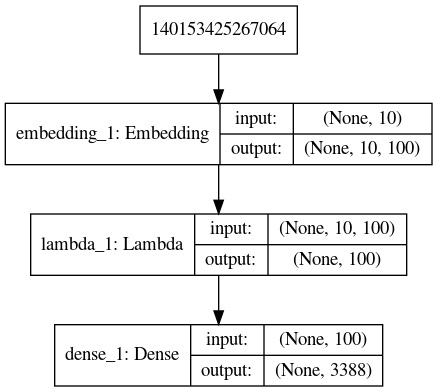

In [12]:
Image(model_to_dot(gph, show_shapes=True).create(prog='dot', format='png'))

## TRAIN

In [13]:
for ite in range(5):
    loss = 0.
    for x_input, y_label in dataloader(corpus[:5], window_size, vocab_size):
        loss += gph.train_on_batch(x_input, y_label)
    print(ite, loss)

0 455.06133365631104
1 453.7306823730469
2 452.33678245544434
3 450.8035249710083
4 449.06471014022827


## Embedding

In [14]:
embd = gph.get_weights()[0][:5,:]
for word, i in tokenizer.word_index.items():
    print('{} {}\n'.format(word, ' '.join(map(str, list(embd[i, :])))))
    if i == 4:
        break

the -0.038172584 0.011961838 -0.016645832 0.04405228 -0.029251114 0.007384427 -0.05477259 0.03343365 -0.023302406 -0.07674626 -0.020435913 -0.048486173 -0.07644062 -0.042216122 -0.01045193 -0.02111131 0.017610718 0.018048199 0.020333713 0.0012664809 -0.104328655 -0.05086611 -0.07442414 0.019997971 -0.03858403 -0.06748172 0.054785084 -0.011206011 0.033584446 -0.03149614 0.029357411 -0.006719595 0.032970257 0.03964748 0.012927518 0.004154993 -0.060827717 0.03711905 0.00683743 0.04155481 0.07760313 -0.08194715 -0.052018777 -0.06989685 0.06520654 0.0666847 0.059637368 0.011565845 -0.007014358 -0.0025673339 0.035810128 0.022644114 0.0026656261 -0.036255393 0.08231073 -0.0061085834 -0.0048067877 0.042398617 -0.04767837 0.025032328 0.02882453 0.039241306 0.029847737 0.010838982 0.037913743 0.03798535 -0.060050238 -0.031424843 0.01578407 -0.00072235905 -0.017982334 -0.0040946538 0.05922818 -0.050706577 -0.024145871 0.05124148 0.05725088 0.06222361 0.07028452 0.005255854 -0.010432643 -0.0057926

Reference:

* https://github.com/nzw0301/keras-examples/blob/master/CBoW.ipynb